<a href="https://colab.research.google.com/github/potterhead04/SOC_2024/blob/main/Unet_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib tqdm

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.decoder4 = DoubleConv(1024 + 512, 512)
        self.decoder3 = DoubleConv(512 + 256, 256)
        self.decoder2 = DoubleConv(256 + 128, 128)
        self.decoder1 = DoubleConv(128 + 64, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.functional.max_pool2d(e1, 2))
        e3 = self.encoder3(nn.functional.max_pool2d(e2, 2))
        e4 = self.encoder4(nn.functional.max_pool2d(e3, 2))
        b = self.bottleneck(nn.functional.max_pool2d(e4, 2))

        d4 = self.decoder4(torch.cat([nn.functional.interpolate(b, size=e4.shape[2:], mode='bilinear', align_corners=True), e4], dim=1))
        d3 = self.decoder3(torch.cat([nn.functional.interpolate(d4, size=e3.shape[2:], mode='bilinear', align_corners=True), e3], dim=1))
        d2 = self.decoder2(torch.cat([nn.functional.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=True), e2], dim=1))
        d1 = self.decoder1(torch.cat([nn.functional.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=True), e1], dim=1))

        return self.final_conv(d1)


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3644221.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 483554.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4535926.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11766849.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
def train_model(model, dataloader, epochs, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}')
    return model

model = UNet(in_channels=1, num_classes=1)
trained_model = train_model(model, train_dataloader, epochs=15, lr=1e-3)


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 938/938 [01:39<00:00,  9.40it/s]


Epoch 1/15, Loss: 0.0226


100%|██████████| 938/938 [01:39<00:00,  9.42it/s]


Epoch 2/15, Loss: 0.0001


100%|██████████| 938/938 [01:39<00:00,  9.41it/s]


Epoch 3/15, Loss: 0.0001


100%|██████████| 938/938 [01:39<00:00,  9.40it/s]


Epoch 4/15, Loss: 0.0001


100%|██████████| 938/938 [01:39<00:00,  9.40it/s]


Epoch 5/15, Loss: 0.0001


100%|██████████| 938/938 [01:40<00:00,  9.37it/s]


Epoch 6/15, Loss: 0.0001


100%|██████████| 938/938 [01:40<00:00,  9.33it/s]


Epoch 7/15, Loss: 0.0001


100%|██████████| 938/938 [01:40<00:00,  9.32it/s]


Epoch 8/15, Loss: 0.0001


100%|██████████| 938/938 [01:40<00:00,  9.34it/s]


Epoch 9/15, Loss: 0.0001


100%|██████████| 938/938 [01:40<00:00,  9.38it/s]


Epoch 10/15, Loss: 0.0008


100%|██████████| 938/938 [01:39<00:00,  9.39it/s]


Epoch 11/15, Loss: 0.0000


100%|██████████| 938/938 [01:39<00:00,  9.40it/s]


Epoch 12/15, Loss: 0.0000


100%|██████████| 938/938 [01:39<00:00,  9.39it/s]


Epoch 13/15, Loss: 0.0000


100%|██████████| 938/938 [01:39<00:00,  9.41it/s]


Epoch 14/15, Loss: 0.0000


100%|██████████| 938/938 [01:39<00:00,  9.39it/s]

Epoch 15/15, Loss: 0.0000


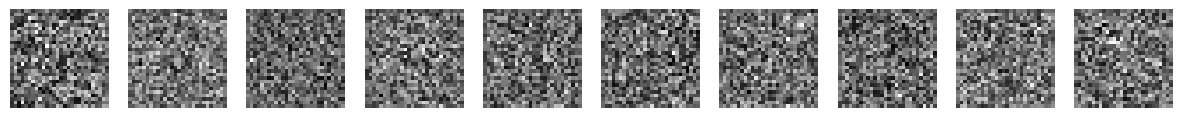

In [6]:
def generate_samples(model, n_samples):
    model.eval()
    samples = []
    with torch.no_grad():
        for _ in range(n_samples):
            noise = torch.randn(1, 1, 28, 28).to(next(model.parameters()).device)
            sample = model(noise)
            samples.append(sample.cpu().numpy().squeeze())
    return samples

samples = generate_samples(trained_model, 10)
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, sample in enumerate(samples):
    axes[i].imshow(sample, cmap='gray')
    axes[i].axis('off')
plt.show()
